In [3]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [47]:
prob = pd.read_csv('20long.csv')
prob["binary"] = prob["F3 probability"].round()
prob.binary = prob.binary.astype(int)

In [95]:
prob[(prob["F3 probability"] < 0) | (prob["F3 probability"] > 1)]

,seq,F1 probability,F2 probability,F3 probability,F4 probability,F5 probability,F6 probability,F7 probability,F8 probability,binary


In [33]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACUGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'U':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [34]:
one_hot_encode((prob["seq"][0]))

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [35]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [37]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

In [38]:
full_train_df, test_df = quick_split(prob)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

train_df.head(10)

Train: (7482, 10)
Val: (1871, 10)
Test: (2339, 10)


,seq,F1 probability,F2 probability,F3 probability,F4 probability,F5 probability,F6 probability,F7 probability,F8 probability,binary
0,UGAAUUAGGAGGGUAUAGAAAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.073984,0.926016,0.0
1,AAUACGAGAGGAGGAAGGCAAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0
4,UUACUACGUGGAGAAAAGAGAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.016631,0.983369,0.0
5,AGAGAUAGAGGAGGAUUAAAAUG,0.0,0.0,0.0,0.000606,0.0,0.000000,0.000000,0.999394,0.0
6,AUAUGGUGGAGGAAAUAGUCAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.012675,0.987325,0.0
8,GUAUGAAGAGGAGAAAAGGUAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0
9,GUACGAAGAGGAGGAAUAUAAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033742,0.966258,0.0
11,AGAAGAGGAGGACUGAGAUGAUG,0.0,0.0,0.0,0.000000,0.0,0.000873,0.000000,0.999127,0.0
12,ACAAAGAAUGGAGGUACGUUAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.060905,0.939095,0.0
14,GAAAGUGAUGAGGCAUAGGUAUG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0


In [49]:
prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11692 entries, 0 to 11691
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seq             11692 non-null  object 
 1   F1 probability  11692 non-null  float64
 2   F2 probability  11692 non-null  float64
 3   F3 probability  11692 non-null  float64
 4   F4 probability  11692 non-null  float64
 5   F5 probability  11692 non-null  float64
 6   F6 probability  11692 non-null  float64
 7   F7 probability  11692 non-null  float64
 8   F8 probability  11692 non-null  float64
 9   binary          11692 non-null  int32  
dtypes: float64(8), int32(1), object(1)
memory usage: 867.9+ KB


In [83]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='F3 probability'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

In [84]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='F3 probability',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [85]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

In [86]:
# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        # the 4 is for our one-hot encoded vector length 4!
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        return out

    
# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 
    def forward(self, xb):
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.permute(0,2,1) 
        
        #print(xb.shape)
        out = self.conv_net(xb)
        return out
    
    # __FOOTNOTE 1__

In [126]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
        print("yb.long.squeeze(1):",yb.long().squeeze(1).shape)
    
    #loss = loss_func(xb_out, yb.float()) # for MSE/regression
    # __FOOTNOTE 2__
    loss = loss_func(xb_out, yb.long().squeeze(1)) # for BCE/classification
    
    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)
    
def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt,verbose = True)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb,verbose =True)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.CrossEntropyLoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses

In [127]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE
)

loss batch ****
xb shape: torch.Size([128, 23, 4])
yb shape: torch.Size([128, 1])
yb shape: torch.Size([128])
model out pre loss torch.Size([128, 1])
xb_out: torch.Size([128, 1])
yb: torch.Size([128, 1])
yb.long: torch.Size([128, 1])
yb.long.squeeze(1): torch.Size([128])


IndexError: Target 1 is out of bounds.

In [20]:
def quick_loss_plot(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

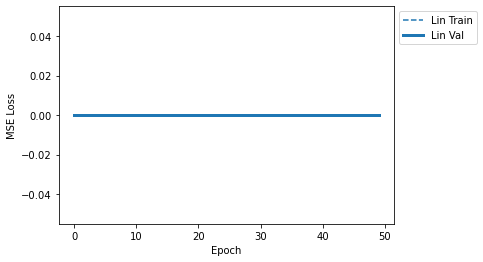

In [21]:
lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

In [23]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE
)

E0 | train loss: 0.151 | val loss: 0.157
E1 | train loss: 0.148 | val loss: 0.155
E2 | train loss: 0.147 | val loss: 0.154
E3 | train loss: 0.146 | val loss: 0.153
E4 | train loss: 0.145 | val loss: 0.153
E5 | train loss: 0.145 | val loss: 0.152
E6 | train loss: 0.144 | val loss: 0.151
E7 | train loss: 0.144 | val loss: 0.151
E8 | train loss: 0.144 | val loss: 0.151
E9 | train loss: 0.144 | val loss: 0.152
E10 | train loss: 0.143 | val loss: 0.152
E11 | train loss: 0.143 | val loss: 0.151
E12 | train loss: 0.143 | val loss: 0.151
E13 | train loss: 0.143 | val loss: 0.150
E14 | train loss: 0.143 | val loss: 0.150
E15 | train loss: 0.143 | val loss: 0.150
E16 | train loss: 0.142 | val loss: 0.151
E17 | train loss: 0.143 | val loss: 0.150
E18 | train loss: 0.142 | val loss: 0.150
E19 | train loss: 0.142 | val loss: 0.150
E20 | train loss: 0.142 | val loss: 0.150
E21 | train loss: 0.142 | val loss: 0.150
E22 | train loss: 0.142 | val loss: 0.150
E23 | train loss: 0.141 | val loss: 0.150
E2

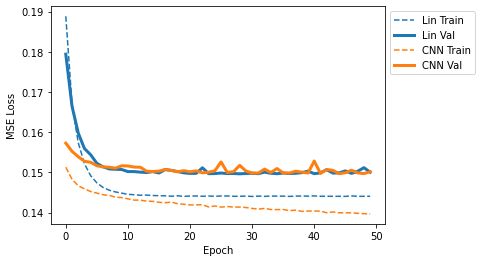

In [24]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

In [95]:
oracle = dict(test_df[['seq','F3 probability']].values)

def quick_seq_pred(model, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    
    '''
    
    df = pd.DataFrame(data = {'seq': [], 'pred': [], 'actual': [], "diff": []})
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = pred.item() - actual
        #print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")
        #df2 = pd.DataFrame(data = {'seq': [dna], 'pred': [pred.item()], 'actual': [actual]})
        df = df.append({'seq': dna, 'pred': pred.item(), 'actual': actual, "diff": diff}, ignore_index = True)
    return df
    

def quick_8mer_pred(model, oracle):

    for seqs in oracle.keys():
        quick_seq_pred(model, oracle, oracle)
        

In [96]:
df = quick_seq_pred(model_lin, oracle.keys(), oracle)

In [97]:
df.head(20)

,seq,pred,actual,diff
0,AAUACGAGAGGAGGAAGGCAAUG,0.066782,0.0,0.066782
1,UAAUGAGUACAUCGAAUCGCAUG,0.269617,0.0,0.269617
2,GGCUUUGUCUACAUCUUUCAAUG,0.225467,0.0,0.225467
3,AUGAGACGGGAGUAAAUAACAUG,0.159584,0.0,0.159584
4,AGAGAGAGGAGAGAGAAAAAAUG,0.092565,0.0,0.092565
5,AGUUACAGAGGAGAACGAGCAUG,0.086097,0.0,0.086097
6,GUAAUGACGGUAAUCUCGUAAUG,0.173785,0.0,0.173785
7,CAAAGAACAGGAGGAACCUUAUG,0.103517,0.0,0.103517
8,AAAAAACGGGAGGAAAGUAAAUG,0.094527,0.0,0.094527
9,AUAUGUAGGAGAGAAAAAAUAUG,0.120179,0.0,0.120179


In [98]:
df.tail(20)

,seq,pred,actual,diff
2319,UCGAUCCCUGGAGGUAAAUGAUG,0.093571,0.0,0.093571
2320,UUAACUACCGGGAGGGCAGGAUG,0.042662,0.0,0.042662
2321,UUUCAAUACGGAGAAUUCAAAUG,0.174346,0.0,0.174346
2322,AUAAGACCGGCCAACACGUUAUG,0.083420,0.0,0.083420
2323,AUCUCGGCAUUACACGACAUAUG,0.240268,0.0,0.240268
2324,CAAAUACUACACGGCUGAGCAUG,0.143736,0.0,0.143736
2325,AAACAAAAGUAAAUGGGAUUAUG,0.250463,0.0,0.250463
2326,AGGGUAAGUCGCUAAUAGUAAUG,0.145499,0.0,0.145499
2327,AUCUUUGGUAUGUUACUAGCAUG,0.199058,0.0,0.199058
2328,GAACAAAGUACACAAACACGAUG,0.166138,0.0,0.166138
